# Suitability Analysis: Best place within the Boston Region for a Tufts UEP student and BU Law student to live without a car 
UEP-239 Final Project\
By: Justina Cheng

[DESCRIPTION]

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim
from pyproj import CRS
from shapely.geometry import LineString, Point, Polygon, box

import rasterio
from rasterio.plot import show
from rasterio import features

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats

## Create and View Base Map of Boston Region Zip Code Tabulation Areas (ZCTAs)
To create a GeoDataFrame of the Boston Region ZCTAs, the following steps were used:
1. Massachusetts outline with detailed coastline was imported from MassGIS as a GeoDataFrame.
1. Massachusetts ZCTAs were imported from the Census Bureau as a GeoDataFrame.
1. The outline and ZCTAs GeoDataFrames were converted to the coordinate reference system (CRS) for the Massachusetts Mainland EPSG 6491.
1. Boundaries for the Boston Region Metropolitan Planning Organization (MPO) were imported from MassDOT as a GeoDataFrame, and the CRS was converted to EPSG 6491.
1. The Boston Region was extracted from the MPO.
1. Massachusetts ZCTAs within the Boston Region were extracted using the centroid of the ZCTAs.
1. Function `read_n_clip` was created to read in a shapefile, convert to the CRS of another GDF, and clip to the extent of the GDF.
1. Massachusetts Surface Water data from MassGIS was processed with `read_n_clip` with the extent of Boston ZCTAs. 

In [2]:
# Import outline of detailed Massachusetts coastline.
outline_25k = gpd.read_file("./data/outline25k/OUTLINE25K_POLY.shp")
outline_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AREA_ACRES  918 non-null    float64 
 1   OBJECTID    918 non-null    int64   
 2   SHAPE_AREA  918 non-null    float64 
 3   SHAPE_LEN   918 non-null    float64 
 4   geometry    918 non-null    geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 36.0 KB


epsg:26986


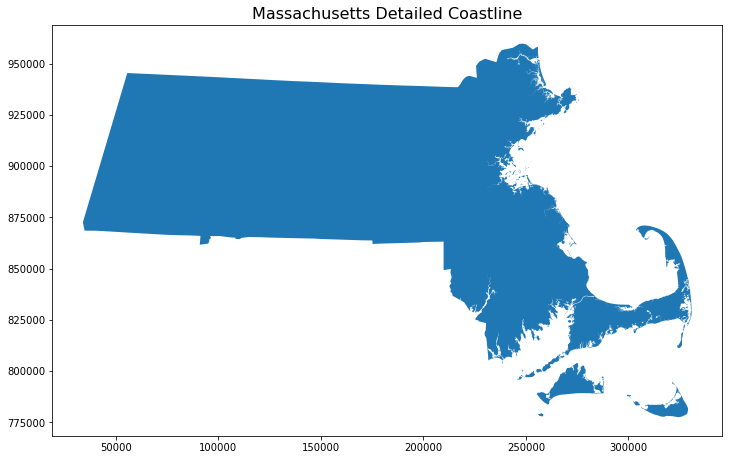

In [3]:
# View CRS and plot.
print(outline_25k.crs)
outline_25k.plot(figsize=(12,12))
plt.title('Massachusetts Detailed Coastline', fontsize=16)
plt.show()

In [4]:
# Import Zip Code Tabulation Areas within Massachusetts.
ma_zcta = gpd.read_file("./data/tl_2010_25_zcta500/tl_2010_25_zcta500.shp")
ma_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 47.1+ KB


epsg:4269


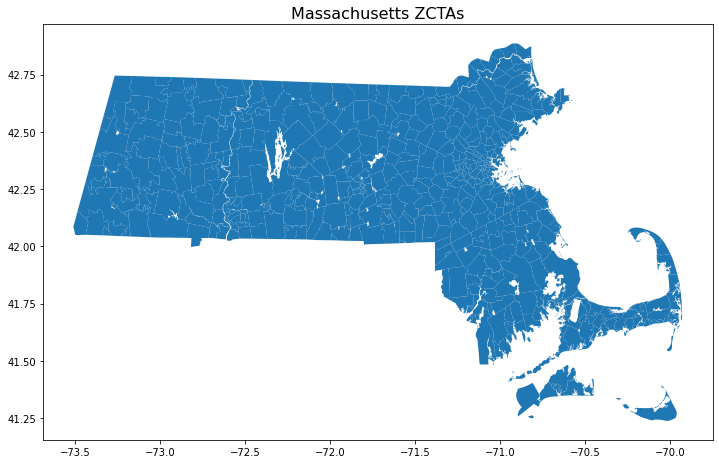

In [5]:
# View CRS and plot.
print(ma_zcta.crs)
ma_zcta.plot(figsize=(12,12))
plt.title('Massachusetts ZCTAs', fontsize=16)
plt.show()

In [6]:
# Convert CRS to Massachusetts Mainland EPSG 6491.
outline_25k = outline_25k.to_crs('epsg:6491')
ma_zcta = ma_zcta.to_crs('epsg:6491')
# Confirm CRSs match.
outline_25k.crs == ma_zcta.crs

True

In [7]:
# Clip ZCTA GDF to 25k MA outline.
ma_zcta_25k = gpd.clip(ma_zcta, outline_25k)
ma_zcta_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 50.9+ KB


In [8]:
# Import boundaries for Boston Region Metropolitan Planning Organization.
mpo = gpd.read_file("./data/MPO_Boundaries/MPO_Boundaries.shp")
mpo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    13 non-null     int64   
 1   MPO         13 non-null     object  
 2   created_us  0 non-null      object  
 3   created_da  13 non-null     object  
 4   last_edite  2 non-null      object  
 5   last_edi_1  13 non-null     object  
 6   GlobalID    13 non-null     object  
 7   ShapeSTAre  13 non-null     float64 
 8   ShapeSTLen  13 non-null     float64 
 9   geometry    13 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(6)
memory usage: 1.1+ KB


In [9]:
# View MPO dataset.
mpo

,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,2,Berkshire,None,1970-01-01,None,1970-01-01,{08FDA544-18B0-412A-B442-287E53E987F7},2.451015e+09,2.471530e+05,"POLYGON ((-8128884.676 5272654.345, -8128962.2..."
1,3,Cape Cod,None,1970-01-01,None,1970-01-01,{B6CD90CF-2F7D-43F2-B251-FA7F8E00EF01},1.067067e+09,1.288227e+06,"MULTIPOLYGON (((-7813968.781 5173329.197, -781..."
2,4,Central Massachusetts,None,1970-01-01,None,1970-01-01,{CC777E14-53C8-42AD-B421-71444DA0BB60},2.487546e+09,2.683265e+05,"POLYGON ((-7977225.352 5223837.273, -7973861.8..."
3,5,Franklin,None,1970-01-01,None,1970-01-01,{4804E708-6B89-4A85-9383-BD91F7589981},1.876456e+09,2.527017e+05,"POLYGON ((-8046511.241 5269691.856, -8045276.8..."
4,6,Montachusett,None,1970-01-01,None,1970-01-01,{F315DA63-C9CF-40EE-8AA7-5ABA2E1FD528},1.772355e+09,2.748684e+05,"POLYGON ((-7976246.504 5267152.001, -7976121.9..."
5,7,Martha's Vineyard,None,1970-01-01,None,1970-01-01,{84077DC9-D5D1-471D-9A64-1E5748F80B92},2.757449e+08,3.701721e+05,"MULTIPOLYGON (((-7859473.886 5083806.270, -785..."
6,8,Merrimack Valley,None,1970-01-01,None,1970-01-01,{C09CD5BA-4FE1-45DD-838E-19F2ECF618DB},7.188680e+08,3.847121e+05,"MULTIPOLYGON (((-7890949.271 5294156.354, -788..."
7,9,Northern Middlesex,None,1970-01-01,None,1970-01-01,{5B2D231C-F8EB-4768-AB7F-F9D02B3EDBBD},5.073539e+08,1.410283e+05,"POLYGON ((-7922038.111 5250986.670, -7923186.5..."
8,10,Nantucket,None,1970-01-01,None,1970-01-01,{633A0B7F-266B-4F07-AA30-EC320231ADAA},1.266795e+08,1.680333e+05,"MULTIPOLYGON (((-7797087.819 5069759.518, -779..."
9,11,Pioneer Valley,None,1970-01-01,None,1970-01-01,{B01F3417-DC74-4561-AE49-935ACC6EF1FF},3.054352e+09,3.206858e+05,"POLYGON ((-8049986.018 5212603.033, -8049953.4..."


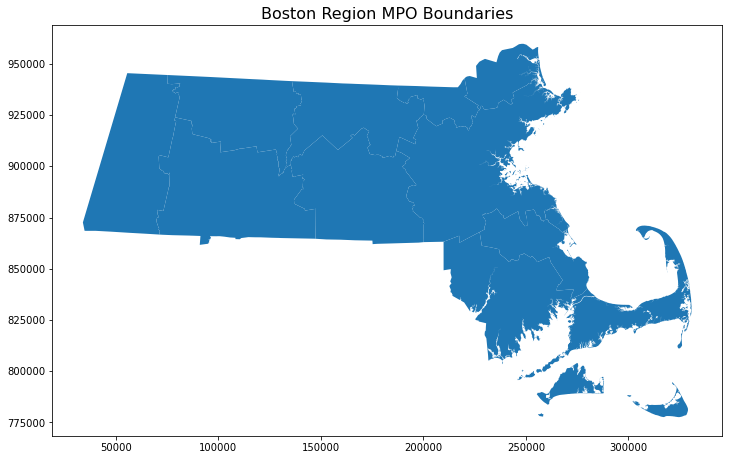

In [10]:
# Convert MPO CRS to EPSG 6491 and plot.
mpo = mpo.to_crs('epsg:6491')
mpo.plot(figsize=(12,12))
plt.title('Boston Region MPO Boundaries', fontsize=16)
plt.show()

In [11]:
# Extract only Boston Region.
boston_region = mpo.loc[mpo.MPO == 'Boston Region'].reset_index()
boston_region

,index,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,10,12,Boston Region,None,1970-01-01,DINOCCOD,2018-04-18,{3801574E-3CF1-4344-BE7C-8B2FBA431DD8},3.524379e+09,1.665026e+06,"MULTIPOLYGON (((261954.246 925125.468, 261961...."


In [12]:
# Extract ZCTAs within the Boston Region using the centroid of the ZCTAs.
boston_zcta = ma_zcta_25k[ma_zcta_25k.centroid.within(boston_region.geometry[0])].reset_index()
boston_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       159 non-null    int64   
 1   STATEFP00   159 non-null    object  
 2   ZCTA5CE00   159 non-null    object  
 3   GEOID00     159 non-null    object  
 4   CLASSFP00   159 non-null    object  
 5   MTFCC00     159 non-null    object  
 6   FUNCSTAT00  159 non-null    object  
 7   ALAND00     159 non-null    int64   
 8   AWATER00    159 non-null    int64   
 9   INTPTLAT00  159 non-null    object  
 10  INTPTLON00  159 non-null    object  
 11  PARTFLG00   159 non-null    object  
 12  geometry    159 non-null    geometry
dtypes: geometry(1), int64(3), object(9)
memory usage: 16.3+ KB


In [13]:
# View the Boston Region ZCTAs.
boston_zcta

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482...."
1,32,25,01867,2501867,B5,G6350,S,25857991,46300,+42.5351829,-071.1054234,N,"POLYGON ((234193.323 919471.462, 234167.381 91..."
2,33,25,01880,2501880,B5,G6350,S,18969895,1554312,+42.5043600,-071.0640609,N,"POLYGON ((233593.527 918646.107, 233786.679 91..."
3,34,25,01730,2501730,B5,G6350,S,34703585,424511,+42.4993313,-071.2819054,N,"POLYGON ((215991.167 913794.709, 215916.137 91..."
4,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,489,25,02030,2502030,B5,G6350,S,39440450,832120,+42.2341291,-071.2834628,N,"POLYGON ((215268.989 884982.344, 215020.550 88..."
155,490,25,02052,2502052,B5,G6350,S,37335006,608718,+42.1845991,-071.3053065,N,"POLYGON ((214616.455 880362.751, 214622.559 88..."
156,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90..."
157,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89..."


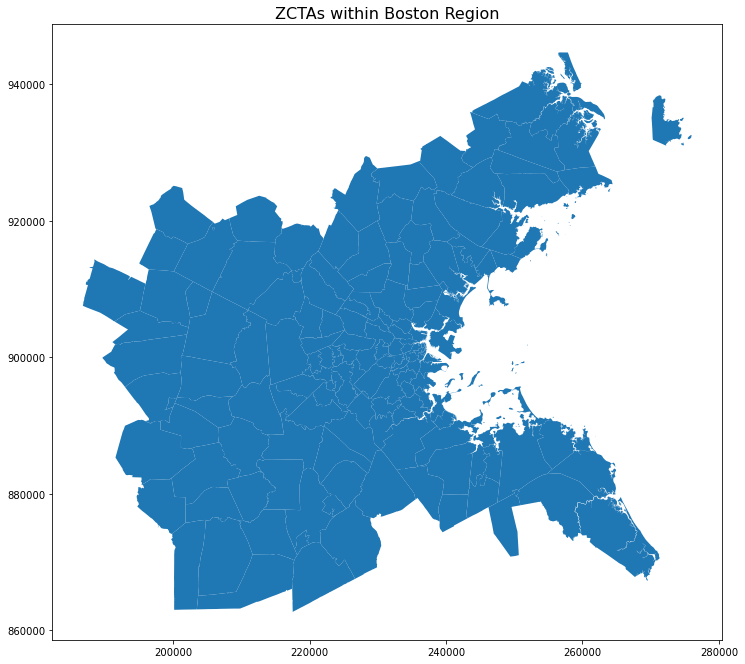

In [14]:
# Plot the Boston Region ZCTAs.
boston_zcta.plot(figsize=(12,12))
plt.title('ZCTAs within Boston Region', fontsize=16)
plt.show()

### Define Function to Read a Shapefile and Clip to Extent

In [64]:
def convert_n_clip(orig_gdf, extent_gdf):
    """
    Takes two GeoDataFrames (GDF): one to process (gdf) and one whose extent will be used to clip.
    Convert to the coordinate reference system (CRS) of the original GDF and clip to the extent of the extent GDF.
    """
    orig_gdf = orig_gdf.to_crs(extent_gdf.crs)
    clipped_gdf = gpd.clip(orig_gdf, extent_gdf).reset_index()
    return clipped_gdf

def read_n_clip(filepath, extent_gdf):
    """
    Takes a filepath for a shapefile and a GeoDataFrame (GDF).
    Reads in the file
    Uses convert_n_clip function to convert to the coordinate reference system (CRS)
    of the GDF and clip to the extent of the GDF. 
    Returns clipped shapefile.
    
    Inputs:
    filepath = relative filepath
    extent = variable name for GDF
    
    Example:
    ma_water = read_n_clip('./data/usa/water.shp', ma_boundary)
    """
    shapefile = gpd.read_file(filepath)
    clipped_shapefile = convert_n_clip(shapefile, extent_gdf)
    return clipped_shapefile
    

In [19]:
# read_n_clip Boston surface water.
boston_water = read_n_clip('./data/hydro25k/HYDRO25K_POLY.shp', boston_zcta)
print(boston_water.crs)
boston_water.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12720 entries, 0 to 12719
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       12720 non-null  int64   
 1   MINOR_TOT   12720 non-null  object  
 2   POLY_CODE   12720 non-null  int64   
 3   PWSID       87 non-null     object  
 4   PALIS_ID    12720 non-null  int64   
 5   SOURCE      12720 non-null  object  
 6   MINOR_NUM   12720 non-null  float64 
 7   RESOLUTION  12720 non-null  object  
 8   NAME        785 non-null    object  
 9   JOIN_ID     12720 non-null  int64   
 10  COASTAL     12720 non-null  int64   
 11  SHAPE_AREA  12720 non-null  float64 
 12  SHAPE_LEN   12720 non-null  float64 
 13  geometry    12720 non-null  geometry
dtypes: float64(3), geometry(1), int64(5), object(5)
memory usage: 1.4+ MB


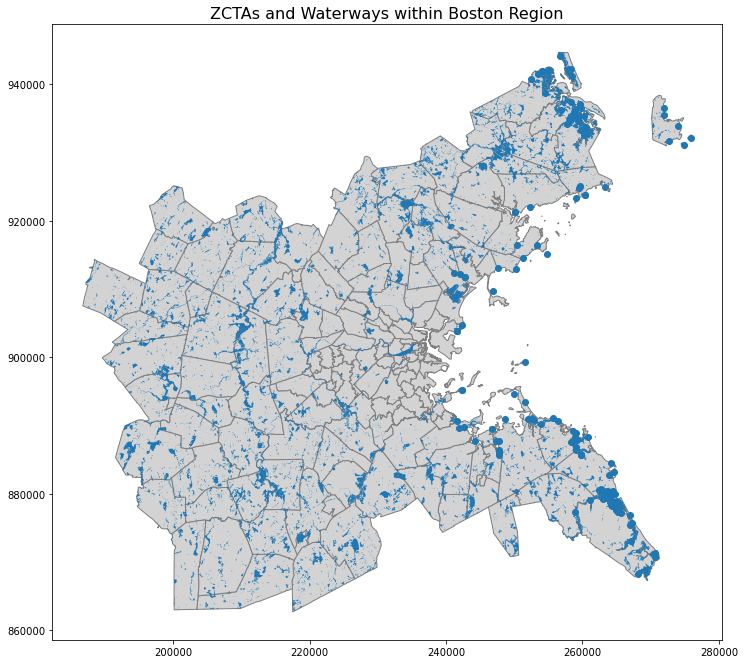

In [20]:
# Plot the Boston Region ZCTAs with surface water.
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax)
plt.title('ZCTAs and Waterways within Boston Region', fontsize=16)
plt.show()

## Find Tufts University and Boston University Locations
To find the locations of Tufts University and Boston University, the Massachusetts Colleges and Universities shapefile was imported from MassGIS as a GeoDataFrame, converted to EPSG 6491, and clipped to the extent of boston_zcta. Tufts University and Boston University were then extracted into a GeoDataGrame

In [24]:
# read_n_clip Boston colleges
colleges = read_n_clip('./data/colleges/COLLEGES_PT.shp', boston_zcta)
print(colleges.crs)
colleges.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       135 non-null    int64   
 1   COLLEGE     135 non-null    object  
 2   CAMPUS      52 non-null     object  
 3   ADDRESS     135 non-null    object  
 4   CITY        135 non-null    object  
 5   ZIPCODE     135 non-null    object  
 6   PLUS_FOUR   22 non-null     object  
 7   GEOG_TOWN   135 non-null    object  
 8   MAIN_TEL    135 non-null    object  
 9   URL         135 non-null    object  
 10  NCES_ID     120 non-null    object  
 11  TYPE        135 non-null    object  
 12  NCES_TYPE   135 non-null    object  
 13  CATEGORY    135 non-null    object  
 14  DEGREEOFFR  135 non-null    object  
 15  AWARDSOFFR  135 non-null    object  
 16  LARGEPROG   79 non-null     object  
 17  CAMPUSSETT  135 non-null    object  
 18  CAMPUSHOUS  135 non-null    obje

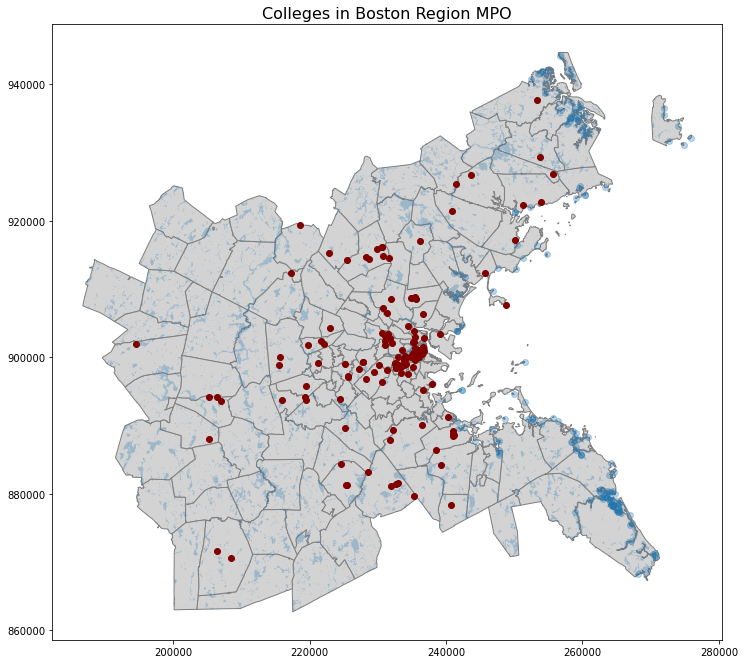

In [25]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
colleges.plot(ax=ax, color='maroon')
plt.title('Colleges in Boston Region MPO', fontsize=16)
plt.show()

In [26]:
college_list = list(colleges.COLLEGE.unique())
college_list

['Dean College',
 "Mafy's Nails Academy",
 'Tri County Regional Vocational Technical High School Adult Education',
 'Toni & Guy Hairdressing Academy',
 'Universal Technical Institute of Massachusetts Inc',
 'University of Phoenix-Boston',
 'Curry College',
 'Massachusetts Bay Community College',
 'Mansfield Beauty Schools',
 'Massachusetts School of Barbering',
 'Newbury College',
 'Boston Career Institute',
 'Boston College',
 'Harvard University',
 'Boston University School of Medicine',
 'Massachusetts College of Pharmacy and Health Science',
 'Massachusetts College of Art and Design',
 'Wentworth Institute of Technology',
 'School of the Museum of Fine Arts',
 'Boston Graduate School of Psychoanalysis Inc',
 'Blessed John Xxiii National Seminary',
 'Simmons College',
 'Northeastern University Professional Advancement Network',
 'Northeastern University',
 'New England Conservatory of Music',
 'Emmanuel College',
 'Ali May Academy',
 'Quincy College',
 'Boston Baptist College',
 'La

In [27]:
colleges_select = colleges.loc[colleges.COLLEGE.isin(['Tufts University', 'Boston University'])]
colleges_select

,index,COLLEGE,CAMPUS,ADDRESS,CITY,ZIPCODE,PLUS_FOUR,GEOG_TOWN,MAIN_TEL,URL,...,TYPE,NCES_TYPE,CATEGORY,DEGREEOFFR,AWARDSOFFR,LARGEPROG,CAMPUSSETT,CAMPUSHOUS,L_SRC,geometry
59,136,Tufts University,Medford/Somerville Campus,419 Boston Avenue,Medford,02155,None,MEDFORD,(617) 628-5000,http://www.tufts.edu,...,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (231416.402 906514.073)
84,163,Boston University,Charles River Campus,1 Silber Way,Boston,02215,None,BOSTON,(617) 353-2000,http://www.bu.edu,...,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Less than one year certificate;One but less th...,None,City: Large,Yes,nces.ed.gov,POINT (232983.739 899977.282)
85,164,Tufts University,Boston Campus,145 Harrison Avenue,Boston,02111,None,BOSTON,(617) 636-7000,http://medicine.tufts.edu/,...,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (236057.132 900054.525)


In [28]:
tufts_bu = colleges_select.iloc[[1, 2]].reset_index()
tufts_bu

,level_0,index,COLLEGE,CAMPUS,ADDRESS,CITY,ZIPCODE,PLUS_FOUR,GEOG_TOWN,MAIN_TEL,...,TYPE,NCES_TYPE,CATEGORY,DEGREEOFFR,AWARDSOFFR,LARGEPROG,CAMPUSSETT,CAMPUSHOUS,L_SRC,geometry
0,84,163,Boston University,Charles River Campus,1 Silber Way,Boston,02215,None,BOSTON,(617) 353-2000,...,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Less than one year certificate;One but less th...,None,City: Large,Yes,nces.ed.gov,POINT (232983.739 899977.282)
1,85,164,Tufts University,Boston Campus,145 Harrison Avenue,Boston,02111,None,BOSTON,(617) 636-7000,...,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (236057.132 900054.525)


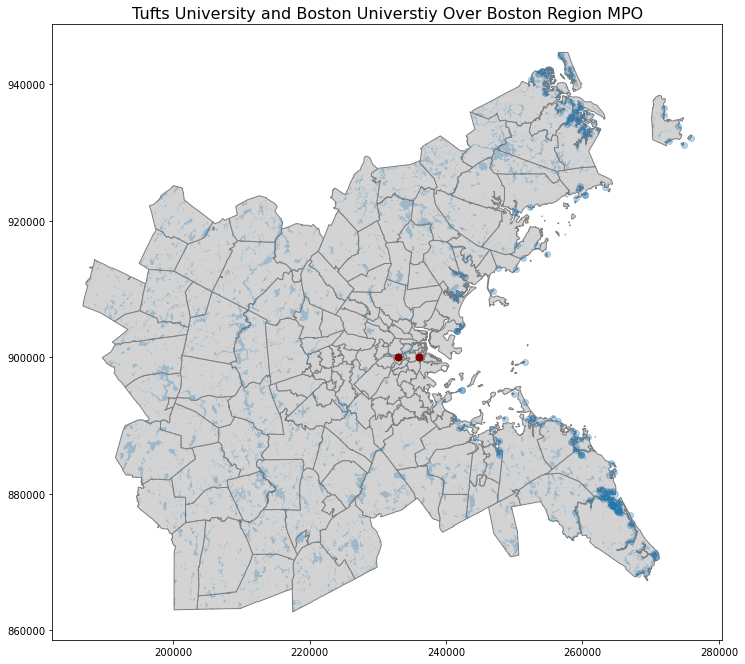

In [29]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
tufts_bu.plot(ax=ax, color='maroon', markersize=50)
plt.title('Tufts University and Boston Universtiy Over Boston Region MPO', fontsize=16)
plt.show()

## Mass Transit Routes and Stops

### MBTA Bus Stops

In [65]:
bos_bus = read_n_clip('./data/MBTA_Bus_Routes_and_Stops/MBTA_Bus_Routes_and_Stops.shp', boston_zcta)
print(bos_bus.crs)
bos_bus.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7710 entries, 0 to 7709
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   index      7710 non-null   int64   
 1   OBJECTID   7710 non-null   int64   
 2   STOP_ID    7710 non-null   int64   
 3   STOP_NAME  7710 non-null   object  
 4   TOWN       7710 non-null   object  
 5   TOWN_ID    7710 non-null   int64   
 6   geometry   7710 non-null   geometry
dtypes: geometry(1), int64(4), object(2)
memory usage: 421.8+ KB


### MBTA Rapid Transit Routes and Stops

In [33]:
bos_rt_route = read_n_clip('./data/mbta_rapid_transit/MBTA_ARC.shp', boston_zcta)
print(bos_rt_route.crs)
bos_rt_route.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   index      138 non-null    int64   
 1   LINE       138 non-null    object  
 2   ROUTE      138 non-null    object  
 3   GRADE      138 non-null    int64   
 4   SHAPE_LEN  138 non-null    float64 
 5   geometry   138 non-null    geometry
dtypes: float64(1), geometry(1), int64(2), object(2)
memory usage: 6.6+ KB


In [34]:
bos_rt_node = read_n_clip('./data/mbta_rapid_transit/MBTA_NODE.shp', boston_zcta)
print(bos_rt_node.crs)
bos_rt_node.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   index     166 non-null    int64   
 1   STATION   166 non-null    object  
 2   LINE      166 non-null    object  
 3   TERMINUS  166 non-null    object  
 4   ROUTE     166 non-null    object  
 5   geometry  166 non-null    geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 7.9+ KB


### Commuter Rail Routes and Stops

In [35]:
bos_train_route = read_n_clip('./data/trains/TRAINS_RTE_TRAIN.shp', boston_zcta)
print(bos_train_route.crs)
bos_train_route.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   index      13 non-null     int64   
 1   COMM_LINE  13 non-null     object  
 2   COMMRAIL   13 non-null     object  
 3   SHAPE_LEN  13 non-null     float64 
 4   geometry   13 non-null     geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 648.0+ bytes


In [36]:
bos_train_node = read_n_clip('./data/trains/TRAINS_NODE.shp', boston_zcta)
print(bos_train_node.crs)
bos_train_node.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       201 non-null    int64   
 1   STATION     201 non-null    object  
 2   C_RAILSTAT  192 non-null    object  
 3   AMTRAK      29 non-null     object  
 4   MAP_STA     109 non-null    object  
 5   LINE_BRNCH  198 non-null    object  
 6   STATE       201 non-null    object  
 7   geometry    201 non-null    geometry
dtypes: geometry(1), int64(1), object(6)
memory usage: 12.7+ KB


### Map mass transit on top of base map

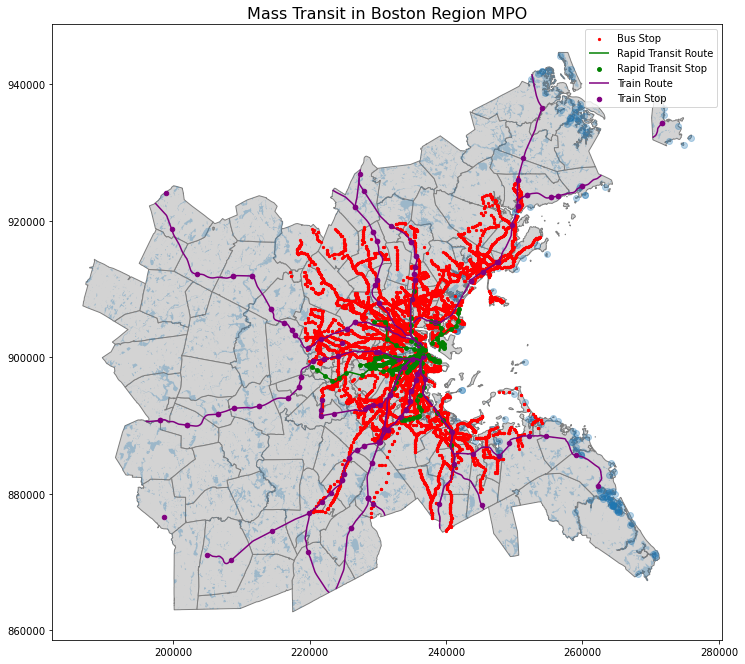

In [37]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
bos_bus.plot(ax=ax, color='red', markersize=5, label='Bus Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_train_route.plot(ax=ax, color='purple', label='Train Route')
bos_train_node.plot(ax=ax, color='purple', markersize=20, label='Train Stop')
plt.title('Mass Transit in Boston Region MPO', fontsize=16)
plt.legend()
plt.show()

## Limit Study Area to Extent of Rapid Transit

In [38]:
# Extract bounds of Boston Rapid Transit nodes.
rt_bounds = bos_rt_node.geometry.total_bounds
rt_bounds

array([220391.71303283, 884240.96758161, 241840.82146882, 909753.44856537])

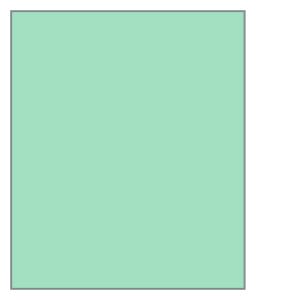

In [39]:
# Creating bounding box with shapely.geometry.box
# shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
rt_bound_box = box(rt_bounds[0], rt_bounds[1], rt_bounds[2], rt_bounds[3])
rt_bound_box

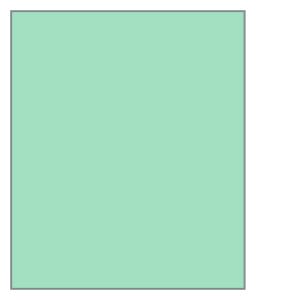

In [40]:
# Store the extent as a Shapely Polygon in a variable called graph_extent:
graph_extent = rt_bound_box.buffer(0.1, join_style=2)
graph_extent

In [41]:
# Extract Boston Region ZCTAs within the graph extent using the centroid of the ZCTAs.
rt_zcta = boston_zcta[boston_zcta.centroid.within(graph_extent)].reset_index()
rt_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   level_0     69 non-null     int64   
 1   index       69 non-null     int64   
 2   STATEFP00   69 non-null     object  
 3   ZCTA5CE00   69 non-null     object  
 4   GEOID00     69 non-null     object  
 5   CLASSFP00   69 non-null     object  
 6   MTFCC00     69 non-null     object  
 7   FUNCSTAT00  69 non-null     object  
 8   ALAND00     69 non-null     int64   
 9   AWATER00    69 non-null     int64   
 10  INTPTLAT00  69 non-null     object  
 11  INTPTLON00  69 non-null     object  
 12  PARTFLG00   69 non-null     object  
 13  geometry    69 non-null     geometry
dtypes: geometry(1), int64(4), object(9)
memory usage: 7.7+ KB


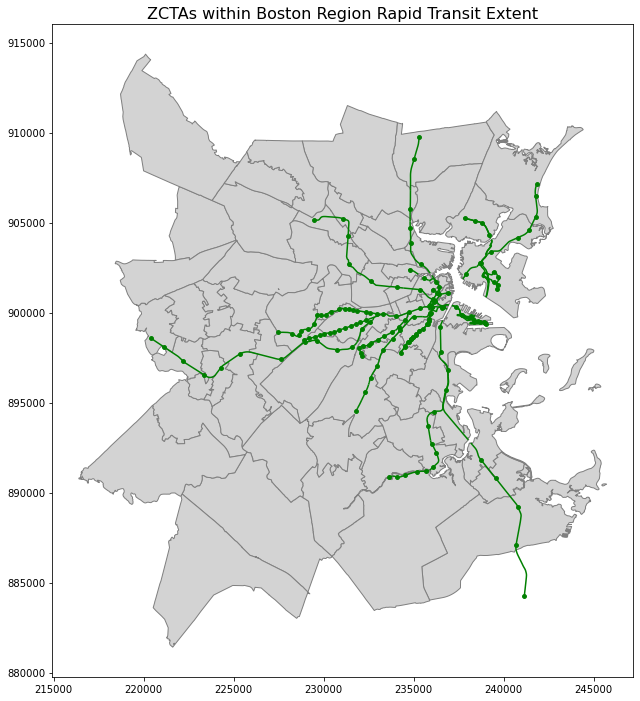

In [43]:
# Plot the Boston Region ZCTAs within graph extent.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
plt.title('ZCTAs within Boston Region Rapid Transit Extent', fontsize=16)
plt.show()

In [44]:
boston_water = gpd.clip(boston_water, rt_zcta)
bos_bus = gpd.clip(bos_bus, rt_zcta)
bos_train_route = gpd.clip(bos_train_route, rt_zcta)
bos_train_node = gpd.clip(bos_train_node, rt_zcta)

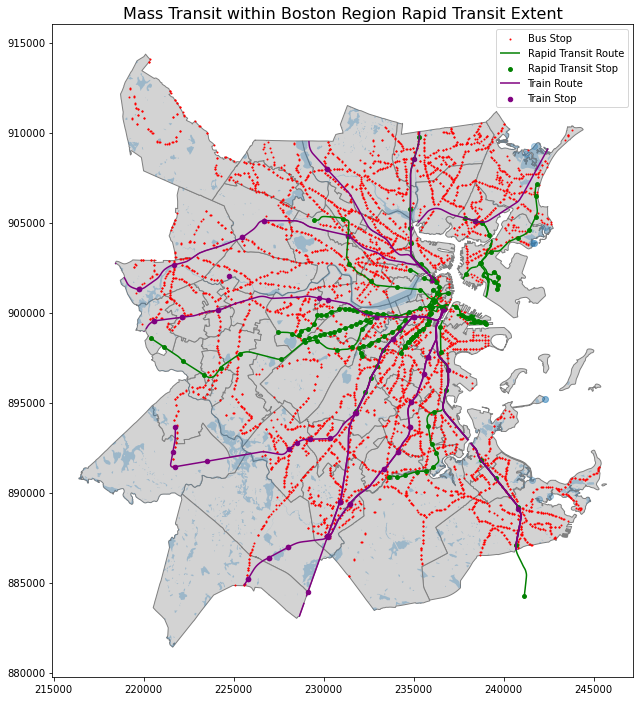

In [54]:
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
bos_bus.plot(ax=ax, color='red', markersize=1, label='Bus Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_train_route.plot(ax=ax, color='purple', label='Train Route')
bos_train_node.plot(ax=ax, color='purple', markersize=20, label='Train Stop')
plt.title('Mass Transit within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

In [ ]:
bos_bus.head()

In [ ]:
bos_bus_latlong = bos_bus.to_crs('epsg:4326')
bos_bus_latlong

In [ ]:
bos_bus['latitude'] = bos_bus_latlong.geometry.y
bos_bus['longitude'] = bos_bus_latlong.geometry.x
bos_bus.head()

In [ ]:
m_1 = folium.Map(location=[42.32, -71.0589], tiles='openstreetmap', zoom_start=20)
mc_1 = MarkerCluster()
for idx, row in bos_bus.iterrows():
    mc_1.add_child(folium.Marker([row['latitude'], row['longitude']], icon=folium.Icon(color='red', icon='bus')))

mc_1.add_to(m_1)
m_1

## Distance to Necessities/Amenities
Amenities are defined as food/groceries, healthcare institutions (acute care, urgent care, hospitals, etc.), safety (firestations)

### Create graph_extent in latitude-longitude to use with `OSMnx`

In [46]:
# Extract bounds of Boston Rapid Transit nodes.
rt_bounds_latlong = bos_rt_node.to_crs('epsg:4326').geometry.total_bounds
rt_bounds_latlong

array([-71.25255434,  42.20753726, -70.99166451,  42.4375046 ])

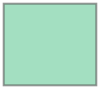

In [47]:
# Creating bounding box with shapely.geometry.box
# shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
rt_bound_box_latlong = box(rt_bounds_latlong[0], rt_bounds_latlong[1], rt_bounds_latlong[2], rt_bounds_latlong[3])
rt_bound_box_latlong

<class 'shapely.geometry.polygon.Polygon'>


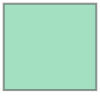

In [48]:
# Store the extent as a Shapely Polygon in a variable called graph_extent:
graph_extent_latlong = rt_bound_box_latlong.buffer(0.1, join_style=2)
print(type(graph_extent_latlong))
graph_extent_latlong

### Groceries within extent

In [49]:
grocery_tags = {'shop':['supermarket', 'greengrocer', 'bakery', 'butcher', 'deli', 'dairy', 'farm', 'seafood', 'wholesale']}
grocery = ox.geometries_from_polygon(graph_extent_latlong, grocery_tags)
grocery

,unique_id,osmid,element_type,brand,brand:wikidata,brand:wikipedia,name,note,shop,geometry,...,name:zh-Hant,building:colour,building:min_level,roof:colour,UPDATE_DAT,operator:wikidata,operator:wikipedia,landuse,ways,type
0,node/314092543,314092543,node,Stop & Shop,Q3658429,en:Stop & Shop,Stop & Shop,store new since 2006 aerial imagery,supermarket,POINT (-71.06527 42.32634),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/355795164,355795164,node,NaN,NaN,NaN,La Ronga Bakery & Delicatessen,NaN,bakery,POINT (-71.10957 42.38406),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/358260788,358260788,node,NaN,NaN,NaN,Stop & Shop,NaN,supermarket,POINT (-70.95894 42.46982),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/431377975,431377975,node,NaN,NaN,NaN,Quebrada Baking Co.,NaN,bakery,POINT (-71.14270 42.40586),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/460001186,460001186,node,NaN,NaN,NaN,Star Market,NaN,supermarket,POINT (-71.11829 42.38975),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,way/845207546,845207546,way,NaN,NaN,NaN,Randolph Fish Market,NaN,seafood,"POLYGON ((-71.04671 42.16853, -71.04673 42.168...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,way/886888575,886888575,way,NaN,NaN,NaN,Vitória Meat Market,NaN,butcher,"POLYGON ((-71.05170 42.41866, -71.05155 42.418...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,retail,NaN,NaN
364,way/935169163,935169163,way,Market Basket,Q2079198,en:Market Basket (New England),Market Basket,NaN,supermarket,"POLYGON ((-71.13222 42.50575, -71.13240 42.506...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,relation/5151441,5151441,relation,Wegmans,Q11288478,NaN,Wegmans,NaN,supermarket,"POLYGON ((-71.15450 42.20736, -71.15389 42.207...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[345868369, 345868370]",multipolygon


In [66]:
grocery = convert_n_clip(grocery, rt_zcta)
grocery

,level_0,index,unique_id,osmid,element_type,brand,brand:wikidata,brand:wikipedia,name,note,...,name:zh-Hant,building:colour,building:min_level,roof:colour,UPDATE_DAT,operator:wikidata,operator:wikipedia,landuse,ways,type
0,0,0,node/314092543,314092543,node,Stop & Shop,Q3658429,en:Stop & Shop,Stop & Shop,store new since 2006 aerial imagery,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,node/355795164,355795164,node,NaN,NaN,NaN,La Ronga Bakery & Delicatessen,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,node/431377975,431377975,node,NaN,NaN,NaN,Quebrada Baking Co.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4,node/460001186,460001186,node,NaN,NaN,NaN,Star Market,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5,node/460211013,460211013,node,NaN,NaN,NaN,Star Market,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,238,353,way/552434369,552434369,way,NaN,NaN,NaN,BJ's Wholesale Club,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,239,361,way/816585252,816585252,way,NaN,NaN,NaN,Super Stop & Shop,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,240,363,way/886888575,886888575,way,NaN,NaN,NaN,Vitória Meat Market,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,retail,NaN,NaN
241,241,365,relation/5151441,5151441,relation,Wegmans,Q11288478,NaN,Wegmans,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[345868369, 345868370]",multipolygon


### Health services within extent

In [51]:
comm_health = read_n_clip('./data/chcs/CHCS_PT.shp', rt_zcta)
comm_health

,index,SITE_NAME,SITE_TYPE,ADMIN_ONLY,ADDRESS,ADDRESS_OT,MAIL_CITY,ZIP,PO_BOX,TOWN,TOWN_ID,SATELLITE,EYE,DENTAL,METHOD,GIS_ID,MCHC_CODE,MAD_ID,geometry
0,1,Chinatown Clinic,NOS,N,885 Washington Street,None,Boston,02111,None,BOSTON,35,Y,N,N,G,S99,SCCHC,35145770,POINT (235848.295 899811.714)
1,3,St. Francis House Clinic,HOMELESS,N,39 Boylston Street,None,Boston,02116,None,BOSTON,35,Y,N,N,G,S101,BHCHP,35018316,POINT (235955.316 900313.222)
2,8,Teen Health Center at Cambridge Rindge and Lat...,SCHOOL,N,459 Broadway,None,Cambridge,02138,None,CAMBRIDGE,49,Y,N,N,G,S106,CHA,3624789,POINT (231966.092 902732.932)
3,9,The Great Hall,NOS,N,6 Norfolk Street,None,Dorchester,02124,None,BOSTON,35,Y,N,N,G,S107,CSHC,35103391,POINT (235304.694 893366.484)
4,11,Upham's Corner Adolescent Health & WIC,NOS,N,500 Columbia Road,None,Dorchester,02125,None,BOSTON,35,Y,N,N,G,S111,UCHC,35035283,POINT (235647.822 896122.920)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,180,NEW Health at Charlestown High School,SCHOOL,N,240 Medford Street,None,Charlestown,02129,None,BOSTON,35,Y,N,N,G,None,NEWH,35093717,POINT (236147.141 903383.303)
81,182,South Boston Health Seaport,NOS,N,505 Congress Street,None,South Boston,02210,None,BOSTON,35,Y,N,N,G,None,SBCHC,35344584,POINT (237814.914 899819.147)
82,183,Dr. Gerald Hass Center,SCHOOL,N,400 Shawmut Avenue,Blackstone Innovation School,Boston,02118,None,BOSTON,35,Y,N,N,G,None,SECHC,35169641,POINT (235185.345 898966.163)
83,186,Whittier Street Health Center @ Quincy Commons,NOS,N,278 Blue Hill Avenue,None,Roxbury,02119,None,BOSTON,35,Y,N,N,G,None,WSHC,35351824,POINT (234751.256 896116.921)


In [52]:
hospitals = read_n_clip('./data/acute_care_hospitals/HOSPITALS_PT.shp', rt_zcta)
hospitals

,index,IDNUMBER,DPHID,NAME,SHORTNAME,ADDRESS,TOWN,GEOG_TOWN,ZIPCODE,CHIAREGION,...,TAXSTATUS,BEDCOUNT,ER_STATUS,TRAUMA_ADU,TRAUMA_PED,SPEPUBFUND,FYE,MADID,EMSREGION,geometry
0,0,2069,2069,Beth Israel Deaconess Medical Center East,BIDMC East,330 Brookline Avenue,Boston,BOSTON,02215,Metro Boston,...,Non-profit,248,N,None,None,Not Applicable,2017-09-30,35022096,4,POINT (232494.091 898890.122)
1,1,2085,2085,Steward St. Elizabeth's Medical Center,St. Elizabeth's Medical Center,736 Cambridge Street,Brighton,BOSTON,02135,Metro Boston,...,For profit,252,Y,None,None,Not Applicable,2017-12-31,35156980,4,POINT (229003.958 899958.291)
2,2,2299,2299,Tufts Medical Center,Tufts Medical Center,800 Washington Street,Boston,BOSTON,02111,Metro Boston,...,Non-profit,415,Y,Level 1,Level 1,Not Applicable,2017-09-30,35145764,4,POINT (235963.109 899998.149)
3,4,2167,2167,Massachusetts Eye and Ear Infirmary,Massachusetts Eye and Ear Infirmary,243 Charles Street,Boston,BOSTON,02114,Metro Boston,...,Non-profit,41,Y,None,None,Not Applicable,2017-09-30,35163139,4,POINT (235396.614 901452.905)
4,5,2316,2316,Shriners Hospital For Children - Boston,Shriners Boston,51 Blossom Street,Boston,BOSTON,02114,Metro Boston,...,Non-profit,30,N,None,None,Not Applicable,2017-12-31,35016066,4,POINT (235713.701 901489.419)
5,6,2168,2168,Massachusetts General Hospital,Massachusetts General Hospital,55 Fruit Street,Boston,BOSTON,02114,Metro Boston,...,Non-profit,1035,Y,Level 1,Level 1,Not Applicable,2017-09-30,35155723,4,POINT (235522.402 901501.524)
6,7,2071,2071,Mount Auburn Hospital,Mount Auburn Hospital,330 Mount Auburn Street,Cambridge,CAMBRIDGE,02138,Metro Boston,...,Non-profit,217,Y,None,None,Not Applicable,2017-09-30,3619685,4,POINT (230124.615 902663.512)
7,8,2108,2108,CHA Cambridge Hospital,Cambridge Hospital,1493 Cambridge Street,Cambridge,CAMBRIDGE,02139,Metro Boston,...,Municipal,189,Y,None,None,DSTI,2017-06-30,3618038,4,POINT (232587.749 902768.034)
8,9,2046,2046,CHA Everett Hospital,Everett Hospital,103 Garland Street,Everett,EVERETT,02149,Metro Boston,...,Municipal,162,Y,None,None,DSTI,None,3508585,3,POINT (237885.457 906637.049)
9,10,2038,2038,Lawrence Memorial Hospital of Medford,Lawrence Memorial Hospital of Medford,170 Governors Avenue,Medford,MEDFORD,02155,Metro Boston,...,Non-profit,98,Y,None,None,CHART,2017-09-30,2574987,3,POINT (231971.181 908456.113)


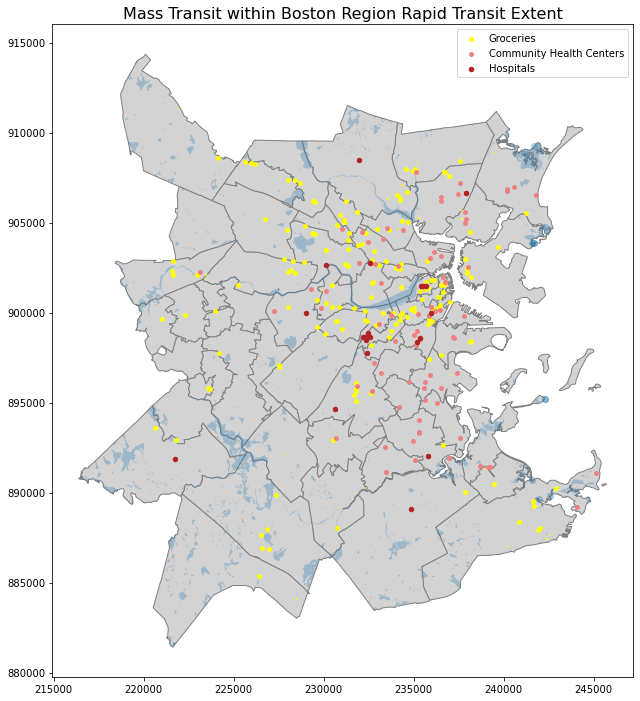

In [56]:
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
grocery.plot(ax=ax, markersize=15, color='yellow', label='Groceries')
comm_health.plot(ax=ax, markersize=15, color='lightcoral', label='Community Health Centers')
hospitals.plot(ax=ax, markersize=20, color='firebrick', label='Hospitals')
plt.title('Mass Transit within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

In [58]:
health_tags = {'healthcare':True}
healthcare = ox.geometries_from_polygon(graph_extent_latlong, health_tags)
healthcare

,unique_id,osmid,element_type,attribution,source,geometry,addr:city,addr:housenumber,addr:state,addr:street,...,massgis:OWNER_TYPE,massgis:POLY_ID,massgis:PRIM_PURP,massgis:PUB_ACCESS,massgis:SITE_NAME,massgis:SOURCE_MAP,massgis:TOWN_ID,owner,ownership,protected
0,node/61348061,61348061,node,Office of Geographic and Environmental Informa...,massgis_import_v0.1_20071008193615,POINT (-71.15744 42.34833),Brighton,438,MA,Washington Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/257489648,257489648,node,NaN,NaN,POINT (-71.06400 42.34981),Boston,755,NaN,Washington Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/460000802,460000802,node,NaN,NaN,POINT (-71.11880 42.38905),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/464793401,464793401,node,NaN,NaN,POINT (-71.06824 42.34717),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/473481734,473481734,node,NaN,NaN,POINT (-71.15405 42.49198),Woburn,675,NaN,Main Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,way/935154172,935154172,way,NaN,NaN,"POLYGON ((-71.16401 42.46106, -71.16412 42.461...",Woburn,358,MA,Cambridge Road,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
332,relation/63951,63951,relation,NaN,NaN,"POLYGON ((-71.07458 42.33442, -71.07447 42.334...",Boston,1,NaN,Boston Medical Center Place,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,relation/65264,65264,relation,NaN,NaN,"POLYGON ((-71.15014 42.32618, -71.14930 42.326...",Chestnut Hill,850,NaN,Boylston Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334,relation/3061383,3061383,relation,NaN,NaN,"MULTIPOLYGON (((-71.10409 42.33458, -71.10488 ...",Boston,75,NaN,Francis Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
healthcare = convert_n_clip(healthcare, rt_zcta)
healthcare

,level_0,index,unique_id,osmid,element_type,attribution,source,geometry,addr:city,addr:housenumber,...,massgis:OWNER_TYPE,massgis:POLY_ID,massgis:PRIM_PURP,massgis:PUB_ACCESS,massgis:SITE_NAME,massgis:SOURCE_MAP,massgis:TOWN_ID,owner,ownership,protected
0,0,0,node/61348061,61348061,node,Office of Geographic and Environmental Informa...,massgis_import_v0.1_20071008193615,POINT (228225.230 899815.766),Brighton,438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,node/257489648,257489648,node,NaN,NaN,POINT (235923.447 900015.140),Boston,755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,node/460000802,460000802,node,NaN,NaN,POINT (231388.803 904351.951),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,node/464793401,464793401,node,NaN,NaN,POINT (235575.109 899720.811),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,6,node/530969568,530969568,node,NaN,NaN,POINT (222792.733 903153.286),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,218,328,way/822922630,822922630,way,NaN,NaN,"POLYGON ((229098.766 899878.355, 229207.092 89...",Brighton,736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,219,330,way/852078315,852078315,way,NaN,NaN,"POLYGON ((229019.391 897380.168, 229024.183 89...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,220,332,relation/63951,63951,relation,NaN,NaN,"POLYGON ((235074.973 898315.608, 235079.682 89...",Boston,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,221,333,relation/65264,65264,relation,NaN,NaN,"POLYGON ((228910.138 897309.951, 228841.345 89...",Chestnut Hill,850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


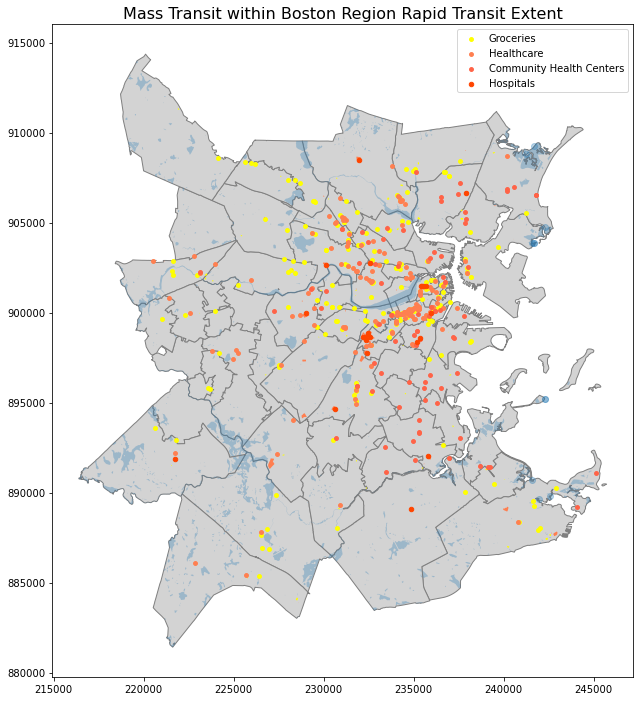

In [61]:
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
grocery.plot(ax=ax, markersize=15, color='yellow', label='Groceries')
healthcare.plot(ax=ax, markersize=15, color='coral', label='Healthcare')
comm_health.plot(ax=ax, markersize=15, color='tomato', label='Community Health Centers')
hospitals.plot(ax=ax, markersize=20, color='orangered', label='Hospitals')
plt.title('Mass Transit within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

## Bike Facilities